In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
%matplotlib inline

In [2]:
DATA_DIR = 'D:/Data/stocks/'

In [3]:
ind = pd.read_excel('D:/Data/index/000300.SH.xlsx')

In [4]:
comp = pd.read_excel('D:/Data/index-component/000300.SH.xlsx')

In [5]:
dic = {}
for code in comp['wind_code']:
    fname = '%s/%s.xlsx'%(DATA_DIR, code)
    temp = pd.read_excel(fname)
    dic[code] = temp['close']
df = pd.DataFrame(dic)

In [6]:
df.head()

,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000060.SZ,000063.SZ,000069.SZ,000100.SZ,000156.SZ,000157.SZ,...,601966.SH,601985.SH,601988.SH,601989.SH,601992.SH,601997.SH,601998.SH,603160.SH,603858.SH,603993.SH
2010-01-04,8.007994,8.554429,1.410065,5.714523,13.591645,19.683323,6.557202,2.308224,1.284125,6.392251,...,NaN,NaN,2.773342,4.546687,NaN,NaN,6.102855,NaN,NaN,NaN
2010-01-05,7.869518,8.360744,1.410065,5.566916,14.242309,20.051843,6.272450,2.379383,1.284125,6.282256,...,NaN,NaN,2.805666,4.528810,NaN,NaN,6.178479,NaN,NaN,NaN
2010-01-06,7.734419,8.360744,1.410065,5.561644,14.545952,19.639968,6.335728,2.326014,1.284125,6.532246,...,NaN,NaN,2.773342,4.582441,NaN,NaN,6.004544,NaN,NaN,NaN
2010-01-07,7.649982,8.296182,1.410065,5.667078,14.242309,18.733841,6.240811,2.308224,1.284125,6.349753,...,NaN,NaN,2.721625,4.528810,NaN,NaN,5.800360,NaN,NaN,NaN
2010-01-08,7.633094,8.352674,1.410065,5.941206,14.068799,18.811881,6.308044,2.348251,1.284125,6.234757,...,NaN,NaN,2.734554,4.481138,NaN,NaN,5.853296,NaN,NaN,NaN


In [12]:
ret_df = df.pct_change()

In [13]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):

    portReturn = np.sum( meanReturns*weights ) * 252
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)

    return portReturn, portStdDev

In [14]:
def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)

    return -(p_ret - riskFreeRate) / p_var

In [15]:
def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate):

    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

In [16]:
maxSharpe = findMaxSharpeRatioPortfolio(ret_df.mean(), ret_df.cov(), 0.0)

In [17]:
ret_port = (ret_df * maxSharpe['x']).sum(axis=1)

In [18]:
ret_ind = ind['close'].pct_change()
ret_ind = ret_ind[ret_ind.index >= ret_port.index[0]]

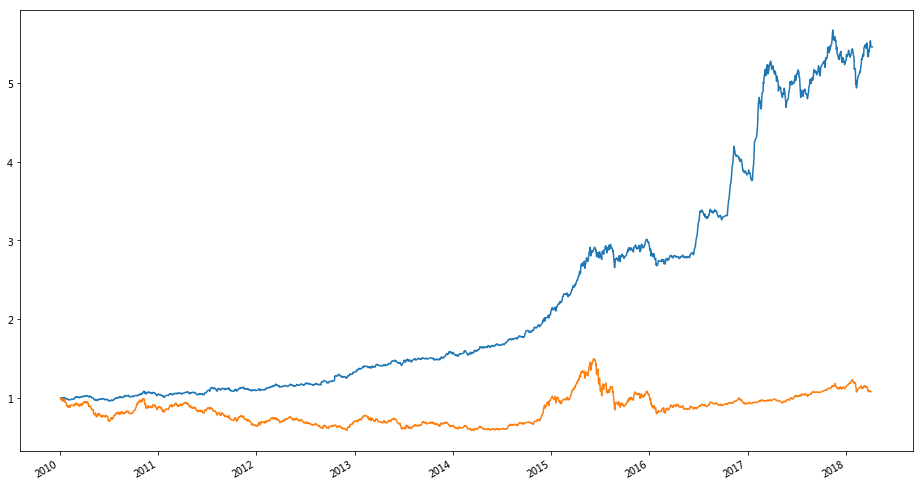

In [19]:
(1 + ret_port).cumprod().plot(figsize=(16, 9))
(1 + ret_ind[ret_ind.index >= '2010-01-01']).cumprod().plot(figsize=(16, 9))

In [20]:
cov = np.cov(ret_ind, ret_port.iloc[:-1])

In [21]:
beta = cov[1][0] / cov[0][0]

In [22]:
beta

0.33259768752136265

In [23]:
beta_risk = pd.Series(index=ret_df.index[::20])
ret_ind = ind['close'].pct_change()
for date in ret_df.index[::20]:
    past_return = ret_df[ret_df.index <= date].iloc[-243:]
    if past_return.shape[0] == 243:
        past_return = past_return.fillna(0)
        maxSharpe = findMaxSharpeRatioPortfolio(past_return.mean(), past_return.cov(), 0.0)
        ret_port = (past_return * maxSharpe['x']).sum(axis=1)
        ret_index = ret_ind[(ret_ind.index >= ret_port.index[0]) & (ret_ind.index <= ret_port.index[-1])]
        cov = np.cov(ret_index, ret_port)
        beta = cov[1][0] / cov[0][0]
        beta_risk.loc[date] = beta

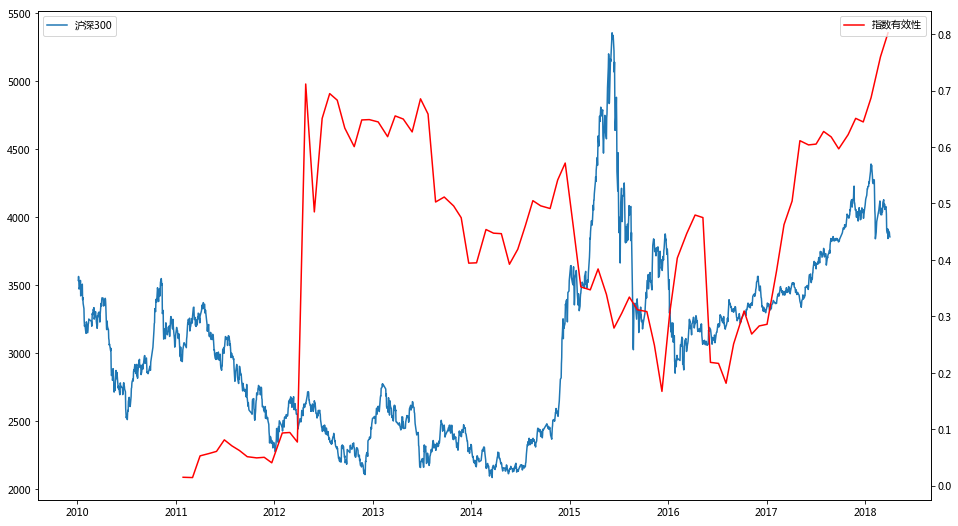

In [36]:
fig, ax1 = plt.subplots(figsize=(16, 9))
ax1.plot(ind[ind.index >= '2010-01-01']['close'], label=u'沪深300')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(beta_risk, color='red', label=u'指数有效性')
ax2.legend(loc='upper right')

In [37]:
beta_risk.to_csv('../data/efficiency.csv')